In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import torch
print(torch.cuda.is_available()) # True
print(torch.cuda.device_count()) # 1
print(torch.cuda.current_device()) # 0
print(torch.cuda.device(0)) # <torch.cuda.device at 0x7efce0b03be0>
print(torch.cuda.get_device_name(0)) # 'GeForce GTX 950M'

True
1
0
NVIDIA TITAN Xp


In [4]:
import sys
sys.path.append("../../..")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-28 19:40:29.903646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 19:40:31.465953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-28 19:40:31.466093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-28 19:40:31.466109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [7]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

In [9]:
# Load the dataset
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [10]:
train_HD = np.array(train_val[:][0])
train_LD = None
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_LD = None
test_Y = np.array(test[:][1])

In [11]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [12]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [13]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [14]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [15]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [16]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [17]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


In [24]:
# Variables to reuse
save_id = 0
model_name = 'ConvolutionalAutoencoder_custom_dim3'
model_dim = 10
model_epc = 10
model_lam = 0

# Reducing with Convolutional Topological Autoencoders (L=0)

In [19]:
topo_reducer = CustomTopoDimRedTransform(
    model_name=model_name,
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/MotionSense20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:2655.6355, Loss-ae:2655.6355, Loss-topo:0.0028
Epoch:2, P:None, Loss:2605.3165, Loss-ae:2605.3165, Loss-topo:0.0253
Epoch:3, P:None, Loss:2607.7461, Loss-ae:2607.7461, Loss-topo:0.0245
Epoch:4, P:None, Loss:2586.4839, Loss-ae:2586.4839, Loss-topo:0.0255
Epoch:5, P:None, Loss:2582.5334, Loss-ae:2582.5334, Loss-topo:0.0247
Epoch:6, P:None, Loss:2610.2918, Loss-ae:2610.2918, Loss-topo:0.0257
Epoch:7, P:None, Loss:2587.3954, Loss-ae:2587.3954, Loss-topo:0.0241
Epoch:8, P:None, Loss:2599.0377, Loss-ae:2599.0377, Loss-topo:0.0253
Epoch:9, P:None, Loss:2637.0212, Loss-ae:2637.0212, Loss-topo:0.0273
Epoch:10, P:None, Loss:2597.6855, Loss-ae:2597.6855, Loss-topo:0.0260


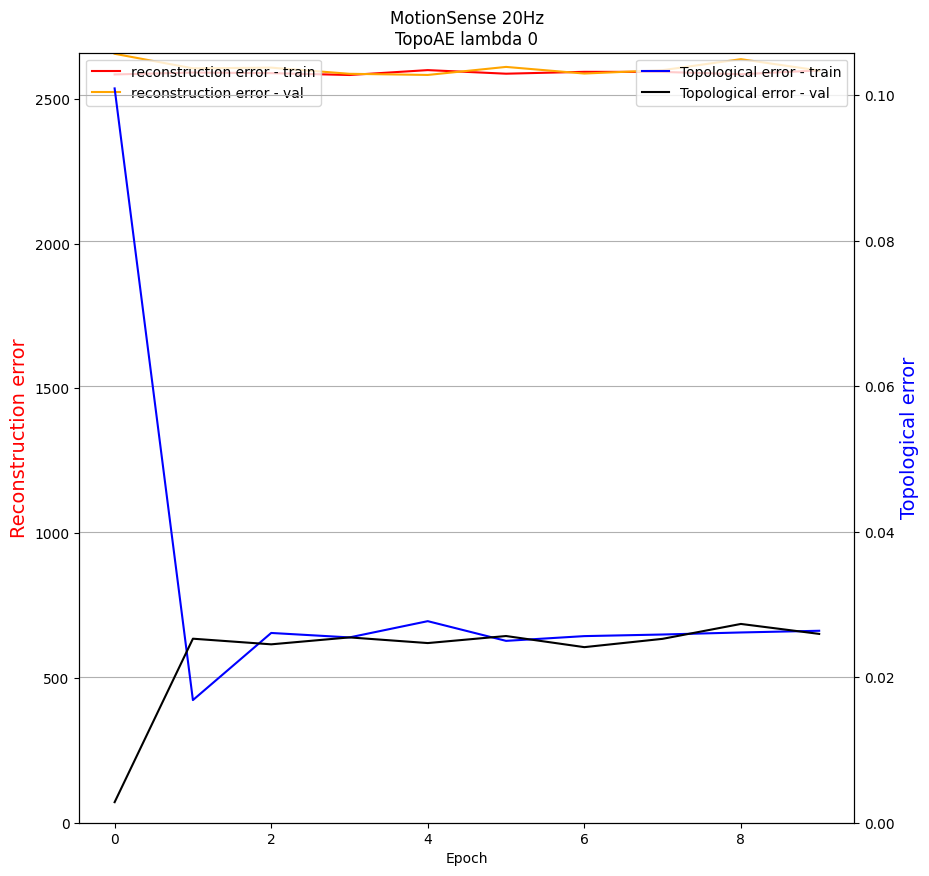

In [20]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

## Save the model

In [25]:
# Variables to reuse
filename = 'data/{}_{}_{}_{}_{}.pkl'.format(model_name, model_lam, model_dim, model_epc, save_id)

data/ConvolutionalAutoencoder_custom_dim3_0_10_10_0.pkl


AssertionError: 

In [22]:
import pickle
filehandler = open(filename, 'wb')
pickle.dump(topo_reducer, filehandler)
filehandler.close()